# G2++ Model Calibration Example

This notebook demonstrates how to calibrate the G2++ interest rate model using historical data.
We will use the `ir_models` package to estimate parameters for the ERB3M dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Ensure the project root is in the path so we can import ir_models
module_path = os.path.abspath(os.getcwd())
if module_path not in sys.path:
    sys.path.append(module_path)

from ir_models.calibration.g2pp import G2ppKalmanMLE

Loading data from data/ERB3M_historic.xlsx...
Data filtered from 2021-01-01 to 2023-12-31.
Number of observations: 36


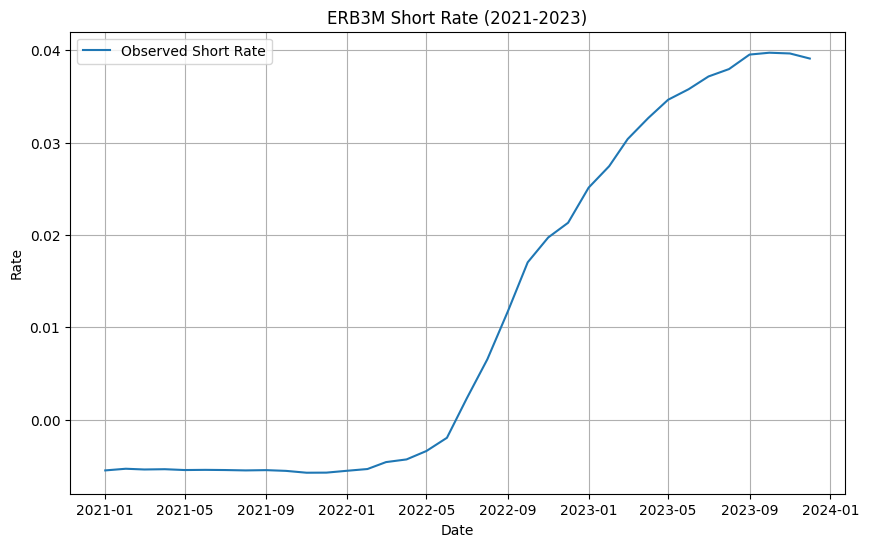

In [2]:
# Load data
file_path = 'data/ERB3M_historic.xlsx'
print(f"Loading data from {file_path}...")
df = pd.read_excel(file_path)

# Filter for 2021-2023 (3 years)
start_date = '2021-01-01'
end_date = '2023-12-31'

mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df_filtered = df.loc[mask].copy()

# Sort by date ascending (oldest first)
df_filtered = df_filtered.sort_values('Date', ascending=True)

print(f"Data filtered from {start_date} to {end_date}.")
print(f"Number of observations: {len(df_filtered)}")

# Extract rates (Dernier column) and convert to decimal
rates = df_filtered['Dernier'].values / 100.0
dates = df_filtered['Date'].values

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(dates, rates, label='Observed Short Rate')
plt.title('ERB3M Short Rate (2021-2023)')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.grid(True)
plt.legend()
plt.show()

In [3]:
# Define phi function
# We set phi(t) = 0 as we don't have any term structure to fit, assuming no deterministic shift for this example.
def phi_func(t):
    return 0.0

dt = 1.0 / 12.0  # Monthly data

In [4]:
# Initialize and run calibration
print("Calibrating G2++ model...")

estimator = G2ppKalmanMLE(
    observations=rates,
    dt=dt,
    phi=phi_func,
    measurement_var=1e-6
)

# Initial guess
initial_guess = {
    "a": 0.1,
    "b": 0.4,
    "sigma": 0.01,
    "eta": 0.01,
    "rho": -0.5,
    "measurement_var": 1e-5,
}

result = estimator.fit(initial_guess=initial_guess)

print("\nCalibration Results:")
print(f"Optimisation success: {result.optimized}")
print(f"Log-likelihood: {result.log_likelihood:.4f}")
print("Estimated Parameters:")
for key, value in result.params.items():
    print(f"  {key}: {value:.6f}")

Calibrating G2++ model...

Calibration Results:
Optimisation success: True
Log-likelihood: 168.9630
Estimated Parameters:
  a: 0.100841
  b: 0.398412
  sigma: 0.008354
  eta: 0.003438
  rho: -0.511312
  measurement_var: 0.000000


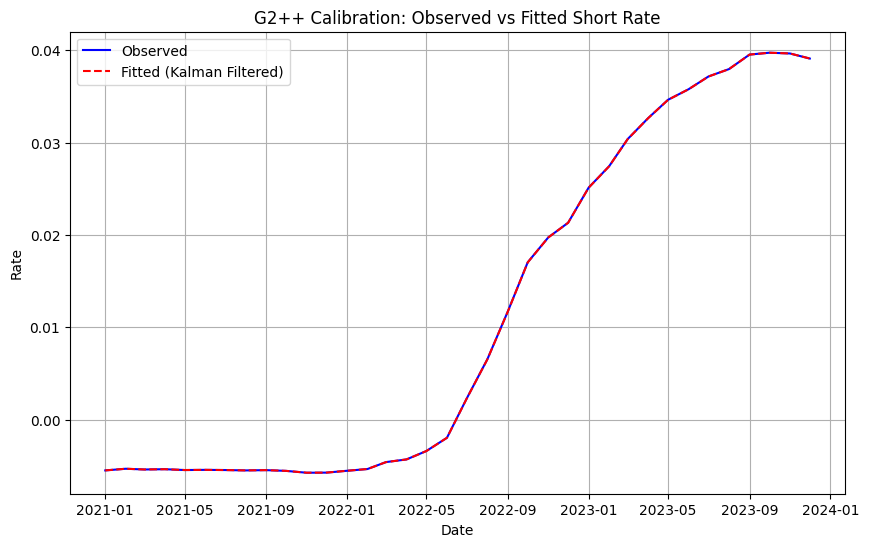

In [5]:
# Visualize fitted states (optional)
# The Kalman filter produces filtered states (means) for x and y.
# We can reconstruct the fitted short rate: r(t) = x(t) + y(t) + phi(t)

filtered_means = result.filtered_states
x_fitted = filtered_means[:, 0]
y_fitted = filtered_means[:, 1]

# Recompute phi on the grid
time_indices = np.arange(len(rates))
phi_values = np.array([phi_func(t * dt) for t in time_indices])

fitted_rates = x_fitted + y_fitted + phi_values

plt.figure(figsize=(10, 6))
plt.plot(dates, rates, 'b-', label='Observed')
plt.plot(dates, fitted_rates, 'r--', label='Fitted (Kalman Filtered)')
plt.title('G2++ Calibration: Observed vs Fitted Short Rate')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.show()